In [158]:
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, data, segmentation, feature, future
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import glob
import cv2
import pandas as pd
from functools import partial
import pickle
import os
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

In [15]:
# Initialize Variables
train_names = []
mask_images = []

feature_list = []


In [3]:
def image_getting():
    
    mask_names = glob.glob('data/archive/lgg-mri-segmentation/kaggle_3m/*/*_mask.tif')

    for i in mask_names:
        train_names.append(i.replace('_mask', ''))
        
    train_images = []
    
    train_masks = []

    for train in train_names:
        img = cv2.imread(train, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        train_images.append(img)
        
    train_images = np.array(train_images)

    for mask in mask_names:
        mask = cv2.imread(mask, 0)
        mask = cv2.resize(mask, (256, 256))
        mask[mask != 0.0] = 1.0
        train_masks.append(mask)

    train_masks = np.array(train_masks)
    train_masks = np.expand_dims(train_masks, axis=3)
    
    
    x_train, x_test, y_train, y_test = train_test_split(train_images,train_masks,test_size = 0.3)

    
    
    
    return x_train, x_test, y_train, y_test
    
        
        
    

In [4]:
x_train, x_test, y_train, y_test = image_getting()

In [207]:
def get_features():
    sigma_min, sigma_max = 1,16
    
    

    features_func = partial(feature.multiscale_basic_features,
                                intensity=True, edges=False, texture=True,
                                sigma_min=sigma_min, sigma_max=sigma_max,
                                channel_axis=-1)
    y = 0 
    for x in x_train:
        features = features_func(x)
        y+=1
        print(y)
        print("################################################################################")

        X = features.reshape(-1, features.shape[2])
        
        feature_list.append(x)
         
    Y = y_train.reshape(-1)
    
    return feature_list, Y
                        

In [208]:
X_train, Y_train = get_features()


1
################################################################################
2
################################################################################
3
################################################################################
4
################################################################################
5
################################################################################
6
################################################################################
7
################################################################################
8
################################################################################
9
################################################################################
10
################################################################################
11
################################################################################
12
################################################################################
1

In [213]:
X_train = np.array(X_train)
print(X_train.shape)
X_train = X_train.reshape(704000,768) 

save = "models/rfc.sav"

rmf = RandomForestClassifier(n_estimators = 50, criterion = "gini", random_state = 42, n_jobs = 7)

rmf.fit(X_train, Y_train)

pickle.dump(rmf, open(save, 'wb'))

(2750, 256, 256, 3)


ValueError: Found input variables with inconsistent numbers of samples: [704000, 540672000]

## VGG Feature Extractor

In [16]:
mask_names = glob.glob('data/archive/lgg-mri-segmentation/kaggle_3m/*/*_mask.tif')

for i in mask_names:
    train_names.append(i.replace('_mask', ''))    
    
x_train, x_test, y_train, y_test = train_test_split(train_names,mask_names,test_size = 0.3)

In [17]:
model = VGG16(weights='imagenet', include_top=False)

In [18]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [19]:
def extract_features(img_path):
    x = load_and_preprocess_image(img_path)
    features = model.predict(x)
    return np.ravel(features)

In [20]:
def feed_images(img_paths):
    features_list = [extract_features(img_path) for img_path in img_paths]
    return np.array(features_list)

In [21]:
feature_list = feed_images(x_train)

1/1 [==============================] - 2s 2s/step


In [ ]:
Y_train  = feed_images(y_train)

1/1 [==============================] - 2s 2s/step


In [11]:
save = "models/rfc.sav"

rmf = RandomForestClassifier(n_estimators = 50, criterion = "gini", random_state = 42, n_jobs = 7)

rmf.fit(feature_list, Y_train)

pickle.dump(rmf, open(save, 'wb'))

ValueError: Found input variables with inconsistent numbers of samples: [2750, 540672000]

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
#test_features = feed_images(x_test)
f1_score = []


for img in y_test:
    
    image = extract_features(img.replace('_mask', ''))
    
    
    prediction = rmf.predict(image)
    prediction[prediction != 0.0] = 1.0
    prediction_image = prediction.reshape(mask.shape)
    
    load_
    monk[monk != 0.0] = 1.0
    
    plt.imsave(f'prediction_images/{file}', prediction_image, cmap='gray')
    
    f1 = f1_score(mask.reshape(-1), prediction)
    print(f1)
    f1_scores.append(f1)
    
    

In [ ]:
    f1_scores = np.array(f1_scores)


## Looking at the Data

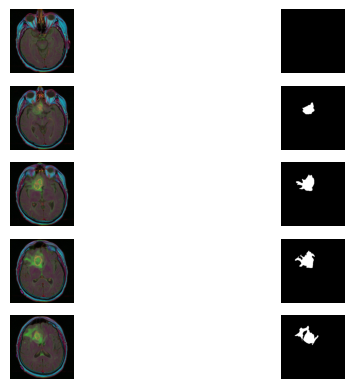

In [7]:
fig, ax = plt.subplots(5, 2)
for i in range(5):
    img = cv2.imread(train_files[i])
    mask = cv2.imread(mask_files[i])
    ax[i][0].imshow(img)
    ax[i][0].axis("off")
    ax[i][1].imshow(mask)
    ax[i][1].axis("off")
plt.show()

In [8]:
print("Image size: ", img.shape, ", Label size: ", mask.shape)


Image size:  (256, 256, 3) , Label size:  (256, 256, 3)


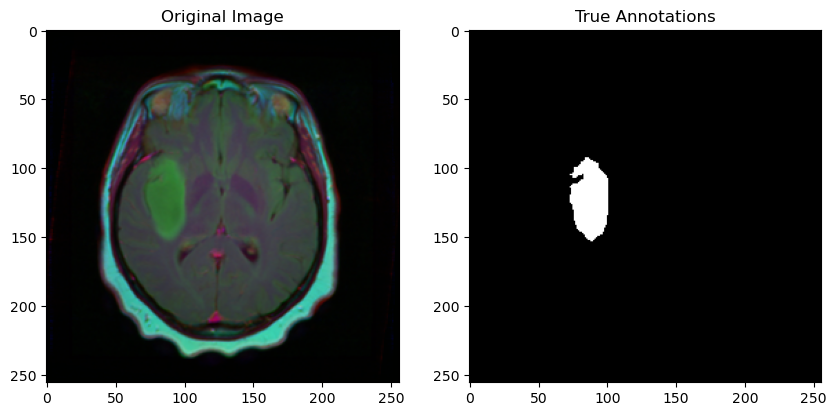

In [18]:
# Plot the original image alongside the annotated image

# set up figure
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 10)

# read in images
image = cv2.imread(train_files[23])
label = cv2.imread(mask_files[23])

# show original image in left panel
ax[0].imshow(image)
ax[0].set_title("Original Image")

# show annotated image on right panel
ax[1].imshow(label)
ax[1].set_title("True Annotations")
plt.show()

In [32]:
#df = pd.DataFrame()

[1 1 0 ... 2 2 0]


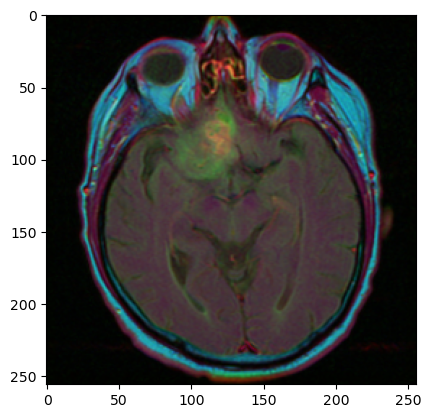

In [51]:
img = cv2.imread(train)
#img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# plt.imshow(img) 
# img2 = img.reshape(-1)
# print(img2)

In [47]:
# def getFeatures():
#     for img in train_files:
#         img = cv2.imread(img)
        
#         img2 = img.reshape(-1)
#         df["OPix"] = img.tolist()
        
#                 ## Gabor Features
#                 #Generate Gabor features
#         num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
#         kernels = []  #Create empty list to hold all kernels that we will generate in a loop
#         for theta in range(2):   #Define number of thetas. Here only 2 theta values 0 and 1/4 . pi 
#             theta = theta / 4. * np.pi
#             for sigma in (1, 3):  #Sigma with values of 1 and 3
#                 for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
#                     for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5

#                         gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
#         #                print(gabor_label)
#                         ksize=5
#                         kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
#                         kernels.append(kernel)
#                         #Now filter the image and add values to a new column 
#                         fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
#                         filtered_img = fimg.reshape(-1)
#                         df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
#                         print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
#                         num += 1  #Increment for gabor column label
        

In [48]:
sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)

,OPix
0,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [..."
1,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [..."
2,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [..."
3,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [..."
4,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [..."
...,...
251,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [3, 3, 3], [..."
252,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 1, 1], [..."
253,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [..."
254,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 1, 1], [..."
